In [759]:
from make_q2_spirals import make_q2_spirals
from make_q2_crescents import make_q2_crescents
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
# خواندن دیتا ها 
data_spirals = make_q2_spirals(student_run_seed=102)
data_crescentsv = make_q2_crescents(student_run_seed=102)
# میخواتم روی gpu اجرا کنم اما زیاد سرعتش یا cpu ام فرق نکرد
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')



خطوط تصمیم رو روی تمامی داده هایم رسم کینم تا دید بهتری داشته باشم برای همین از همه داده ها استفاده میکنم


In [760]:
x_crescentsv = torch.cat([data_crescentsv.X_train,data_crescentsv.X_val,data_crescentsv.X_test])
y_crescentsv = torch.cat([data_crescentsv.y_train,data_crescentsv.y_val,data_crescentsv.y_test])

x_sprials = torch.cat([data_spirals.X_train,data_spirals.X_val,data_spirals.X_test])
y_sprials = torch.cat([data_spirals.y_train,data_spirals.y_val,data_spirals.y_test])

آماده سازی داده های برای آموزش 

In [761]:
# برای اینکه راحتی داده ها رو در کنار هم داتشه باشم 
train_dataFrime_sprials = TensorDataset(data_spirals.X_train.float(),data_spirals.y_train.long())
test_dataFrime_sprials = TensorDataset(data_spirals.X_test.float(),data_spirals.y_test.long())
val_dataFrime_sprials = TensorDataset(data_spirals.X_val.float(),data_spirals.y_val)

train_dataFrime_crescentsv = TensorDataset(data_crescentsv.X_train.float(),data_crescentsv.y_train.long())
test_dataFrime_crescentsv = TensorDataset(data_crescentsv.X_test.float(),data_crescentsv.y_test.long())
val_dataFrime_crescentsv = TensorDataset(data_crescentsv.X_val.float(),data_crescentsv.y_val)
batchSize=32
# برای لود کردن داده ها در بسته بندی ها منظم 32 تایی 
train_load_sprials = DataLoader(train_dataFrime_sprials,batch_size=batchSize,shuffle=True)
test_load_sprials = DataLoader(test_dataFrime_sprials,batch_size=batchSize,shuffle=False)
val_load_sprials = DataLoader(val_dataFrime_sprials,batch_size=batchSize,shuffle=False)


train_load_crescentsv = DataLoader(train_dataFrime_crescentsv,batch_size=batchSize,shuffle=True)
test_load_crescentsv = DataLoader(test_dataFrime_crescentsv,batch_size=batchSize,shuffle=False)
val_load_crescentsv = DataLoader(val_dataFrime_crescentsv,batch_size=batchSize,shuffle=False)



ساخت مدل های ساده تک نورونی 


In [762]:
model_sprials = torch.nn.Sequential(
    torch.nn.Linear(2,1),
    torch.nn.Sigmoid()
)

model_crescentsv = torch.nn.Sequential(
    torch.nn.Linear(2,1),
    torch.nn.Sigmoid()
)
model_crescentsv.to(device)
model_sprials.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

اینجا معیار رو انتخاب میکنیم و تابع بهینه سازی که بعدا توی تابع اموزش ازشون استفاده کنیم

In [763]:
# هم تابع 
# Binary Cross Entropy رو حساب میکنه 
# و هم sigmide روی مدل اعمال میکنه  
criterion = nn.BCEWithLogitsLoss()  
# برای هر مدل یک optimizer تعریف میکنیم
optimizer_cr = torch.optim.Adam(model_crescentsv.parameters(), lr=1e-3)
optimizer_sp = torch.optim.Adam(model_sprials.parameters(), lr=1e-3)

اینجا تابع اموزش رو نوشتم 
ورودی به مدل میدم 
خروجی رو به یک عدد تبدیل میکنم 
بر اساس معیاری که قبل تعریف کردم 
خروجی پیش بینی شده مدل با برچسبی که دارم به معیارم میدم 
و بعد وزن و بایاس های مدل  رو بروزرسانی میکنم 
و در نهایت روند اموزش رو نمایش میدم


In [764]:
def learn(model , data , optimizer,num_epoche):
    losses=[]
    model.train()
    # تعداد دفعاتی که مدل باید اموزش ببینه 
    for epoch in range(num_epoche):
      # این برای نمایش گرافبکی هس
      total_loss = 0
      # حلقه اموزش
      for x_train,y_train in data:
        # ورودی داده های اموزش به مدل لبته به صورت بچ هاس 32 تایی
          out = model(x_train)
          # خروجی باید باه صورت یک عدد دربیاد
          out = out.squeeze().float()
          # همیطور برچسب ها 
          y_train = y_train.float()
          # مقایسه پیش بینی مدل و برچسب هایی که داشتیم 
          loss = criterion(out,y_train)
          # برای اینکه گرادیان قبلی رو لازم نداریم 
          # و هر بچ گرادیان های خودشو حساب میکنه پس باید صفر کنم تا گرادیان های قبلی روی این جدید ها تاثیر نزاره
          optimizer.zero_grad()
          # محاسبه گرادیان برای وزن ها 
          loss.backward()
          # بروزرسانی وزن و بایاس های مدل 
          optimizer.step()
          
          total_loss += loss.item()
      # نمایش loss 
      if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epoche}], Loss: {loss.item():.4f} for {model} ')
      avg_loss = total_loss / len(data)  
      losses.append(avg_loss)
      #نمایش روند اموزش  
    plt.figure(figsize=(6,4))
    plt.plot(losses,label="trining loss ")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(model)
    plt.legend()
    plt.grid(True)
    plt.show()
            

Epoch [100/300], Loss: 0.6077 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 
Epoch [200/300], Loss: 0.5747 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 
Epoch [300/300], Loss: 0.6101 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 


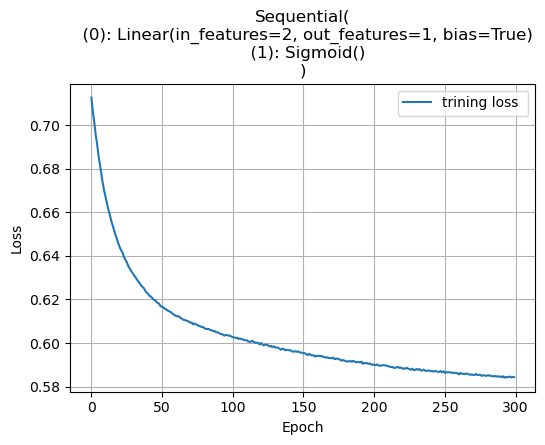

In [765]:
learn(model_crescentsv,train_load_crescentsv,optimizer_cr,300)


Epoch [100/300], Loss: 0.6578 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 
Epoch [200/300], Loss: 0.6944 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 
Epoch [300/300], Loss: 0.5945 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 


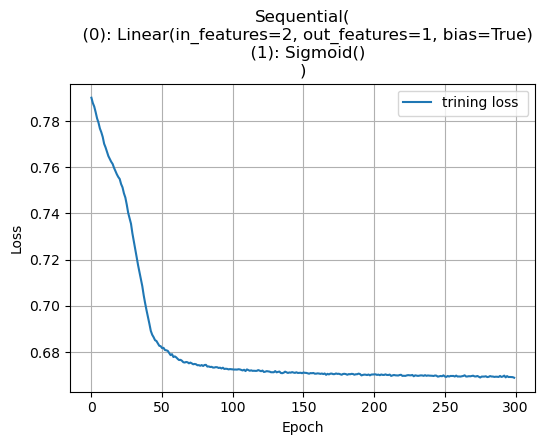

In [766]:
learn(model_sprials,train_load_sprials,optimizer_sp,300)

چون داده های ما متوازن هستند پس از معیار accuracy استفاده میکنم 
برای هر نوع داده train test val یک معیار ارزیابی نوشتم 


In [793]:
def accuracy_train(model,data):
    model.eval()
    correct=0
    total=0
    # حلقه برای تست مدل 
    for x_train,y_train in data:
        out = model(x_train)
        out = out.squeeze().float()
        y_train = y_train.float()
        # اینجا احتمال رو 50 درصد در نظر میگیرم 
        # یعنی خروجی که بین صفر و یک هست اگر از نیم بزرگتر بود مقدارش یک باشه در غیر اینصورت صفر
        pred = (out >0.5).float()
        # محاسبه تعداد پاسخ های درست مدل 
        correct += (pred == y_train).float().sum().item()
        # باید به اندازه کل بچ به توتال اضافه کنیم 
        total += y_train.size(0)
        
    return correct/total
def accuracy_test(model,data):
    model.eval()
    correct=0
    total=0
    for x_test,y_test in data:

        out = model(x_test)
        out = out.squeeze().float()
        y_test = y_test.float()
        pred = (out >0.5).float()
        correct += (pred == y_test).float().sum().item()
        total += y_test.size(0)
    return correct/total
def accuracy_val(model,data):
    model.eval()
    correct=0
    total=0
    for x_val,y_val in data:
        out = model(x_val)
        out = out.squeeze().float()
        y_val = y_val.float()
        pred = (out >0.5).float()
        correct += (pred == y_val).float().sum().item()
        total += y_val.size(0)
    return correct/total

محاسبه دقت مدل

In [768]:
# model_sprials.to(device)
# train_load_sprials = train_load_sprials.to(device)
ac_train = accuracy_train(model_sprials,train_load_sprials)
ac_test = accuracy_test(model_sprials,test_load_sprials)
ac_val = accuracy_val(model_sprials,val_load_sprials)

print(f'accuracy model on sprials')
print(f'accuracy train = {ac_train*100}%  ')
print(f'accuracy validation = {ac_val*100}%  ')
print(f'accuracy test = {ac_test*100}%  ')

ac_train = accuracy_train(model_crescentsv,train_load_crescentsv)
ac_test = accuracy_test(model_crescentsv,test_load_crescentsv)
ac_val = accuracy_val(model_crescentsv,val_load_crescentsv)

print(f'accuracy model on sprials')
print(f'accuracy train = {ac_train*100}%  ')
print(f'accuracy validation = {ac_val*100}%  ')
print(f'accuracy test = {ac_test*100}%  ')


accuracy model on sprials
accuracy train = 59.21428571428572%  
accuracy validation = 52.75%  
accuracy test = 54.50000000000001%  
accuracy model on sprials
accuracy train = 79.0%  
accuracy validation = 81.25%  
accuracy test = 84.0%  


نمایش مرز تصمیم 

In [769]:
def plot_decision_linear(model, X, y, title="decision linear"):

    # model.eval()
    # محاسبه محدوده برای رسم نودار
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # ساخت ماتریس برای رسم 
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    # نقاطی که میخواهیم به مدل بدیم
    grid = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        # تبدیل شبکه به تنسور
        inputs = torch.FloatTensor(grid)
        # پیش بینی  مدل روی شبکه
        preds = torch.sigmoid(model(inputs)) 
        # تبدیل داده ها به شبکه دو بعدی برای هماهنگی با xx , yy
        preds = preds.reshape(xx.shape)
    # رسم 
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, preds, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolor='k')
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()
    # model.to(device)

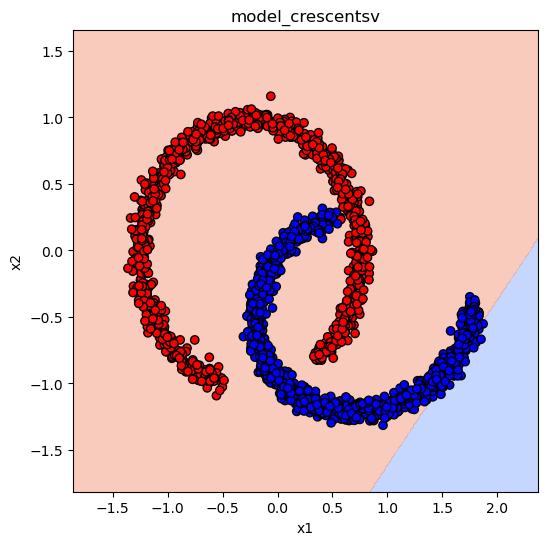

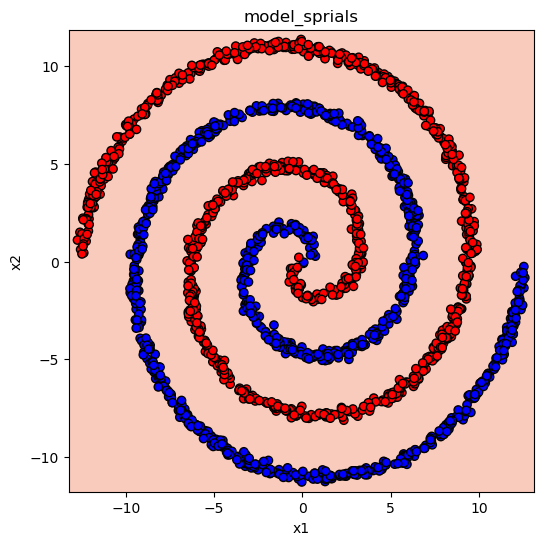

In [770]:
plot_decision_linear(model_crescentsv,x_crescentsv,y_crescentsv,"model_crescentsv")
plot_decision_linear(model_sprials,x_sprials,y_sprials,"model_sprials")


مدل پایه به دلیل خطی بودن نمیتواند خطی بکشد که تمام دادها را تفکیک کند 
این داده ها به صورت مارپیچی هستند و نمتوان با کشیدن یک خط داده ها را به دو قسمت تقسیم کرد به عبارتی مدل خطی برای داده های دو کلاسه که با یک خط قابل تفکیک باشند مناسب است 
مدل کم برازش شده است

آموزش مدل با یک لایه پنهان 10 نورونی

In [833]:
model_sprials_10noron = torch.nn.Sequential(
    torch.nn.Linear(2,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1)
)
model_crescentsv_10noron = torch.nn.Sequential(
    torch.nn.Linear(2,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1)
    
)
    

In [834]:
criterion = nn.BCEWithLogitsLoss()  
optimizer_cr_10n = torch.optim.Adam(model_crescentsv_10noron.parameters(), lr=1e-3)
optimizer_sp_10n = torch.optim.Adam(model_sprials_10noron.parameters(), lr=1e-3)

تابع برای محاسبه دقت و میانگین و انحراف معیار و رسم نمودار اموزش و مرز تصمیم 

In [835]:
def show_all(model,train_load,test_load,val_load,optim,epoch,model_name,x,y):
    learn(model,train_load,optim,epoch)
    total=[]
    for i in range(6):
        acc = accuracy_train(model,train_load)
        total.append(acc)
    ac_mean = np.mean(total)
    ac_std = np.std(total)

    ac_train = accuracy_train(model,train_load)
    ac_test = accuracy_test(model,test_load)
    ac_val = accuracy_val(model,val_load)

    print(f'accuracy {model}')
    print(f'accuracy train = {ac_train*100}%  ')
    print(f'accuracy validation = {ac_val*100}%  ')
    print(f'accuracy test = {ac_test*100}%  ')
    print(f'accuracy mean = {ac_mean*100}%  ')
    print(f'accuracy std = {ac_std}  ')

    plot_decision_linear(model,x,y,f'linear decision for {model_name}')
    # return ac_train,ac_test,ac_val,ac_mean,ac_std

Epoch [100/400], Loss: 0.6720 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 
Epoch [200/400], Loss: 0.6352 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 
Epoch [300/400], Loss: 0.6730 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 
Epoch [400/400], Loss: 0.6712 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 


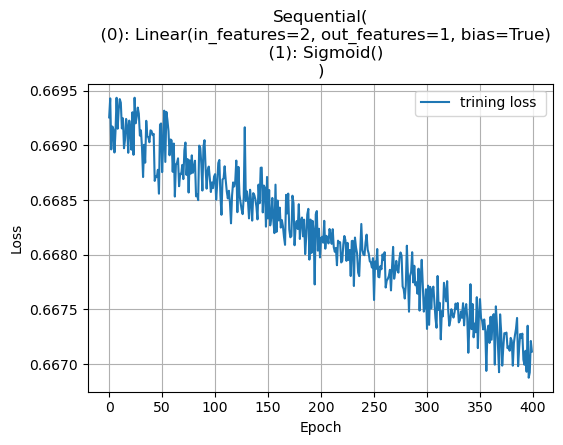

accuracy Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)
accuracy train = 61.142857142857146%  
accuracy validation = 52.5%  
accuracy test = 56.00000000000001%  
accuracy mean = 61.14285714285713%  
accuracy std = 1.1102230246251565e-16  


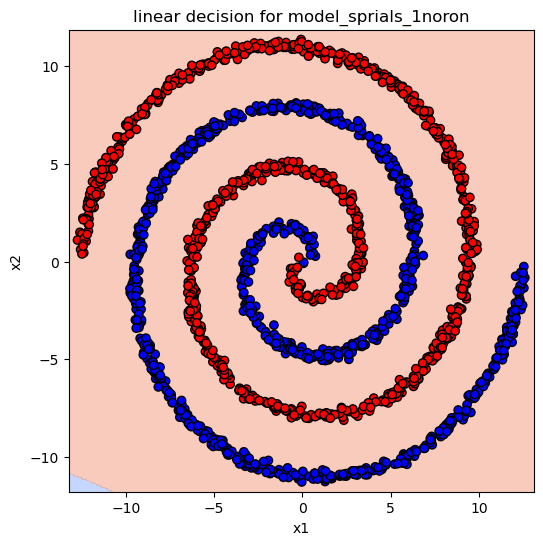

Epoch [100/400], Loss: 0.5638 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 
Epoch [200/400], Loss: 0.5567 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 
Epoch [300/400], Loss: 0.6055 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 
Epoch [400/400], Loss: 0.5275 for Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
) 


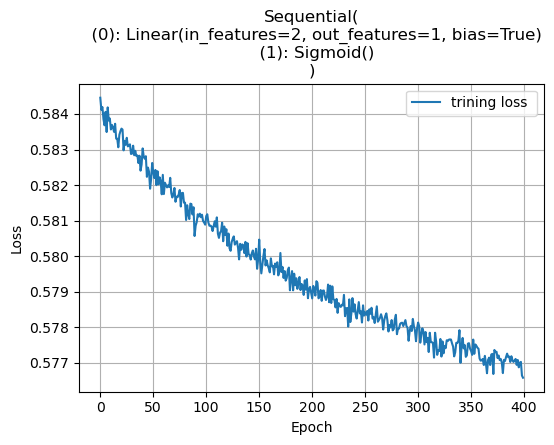

accuracy Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)
accuracy train = 80.28571428571428%  
accuracy validation = 81.75%  
accuracy test = 84.5%  
accuracy mean = 80.28571428571428%  
accuracy std = 0.0  


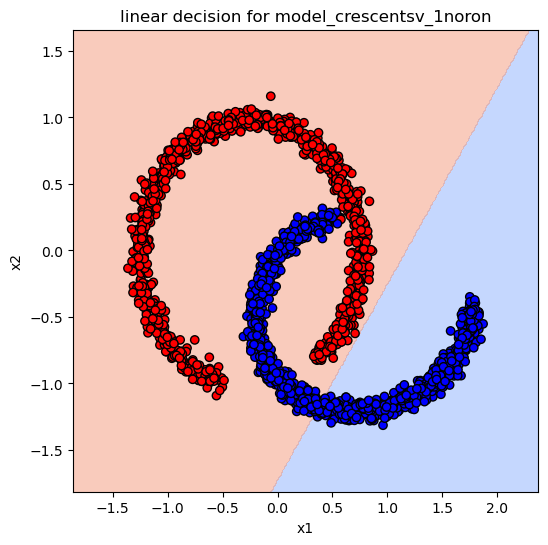

In [838]:
show_all(model_sprials,train_load_sprials,test_load_sprials,val_load_sprials,optimizer_sp,400,"model_sprials_1noron",x_sprials,y_sprials)
show_all(model_crescentsv,train_load_crescentsv,test_load_crescentsv,val_load_crescentsv,optimizer_cr,400,"model_crescentsv_1noron",x_crescentsv,y_crescentsv)

Epoch [100/400], Loss: 0.0578 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [200/400], Loss: 0.0082 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [300/400], Loss: 0.0043 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [400/400], Loss: 0.0006 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 


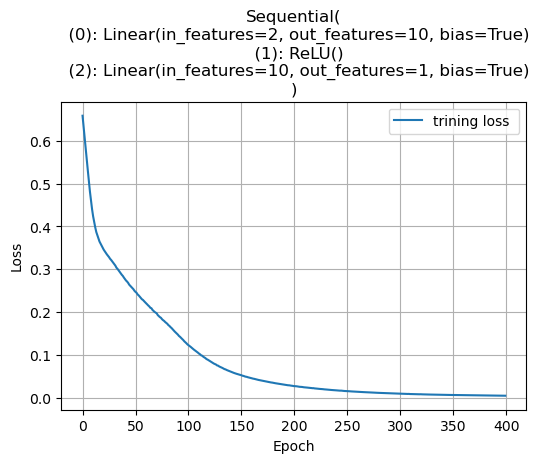

accuracy Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)
accuracy train = 99.92857142857143%  
accuracy validation = 100.0%  
accuracy test = 100.0%  
accuracy mean = 99.92857142857144%  
accuracy std = 1.1102230246251565e-16  


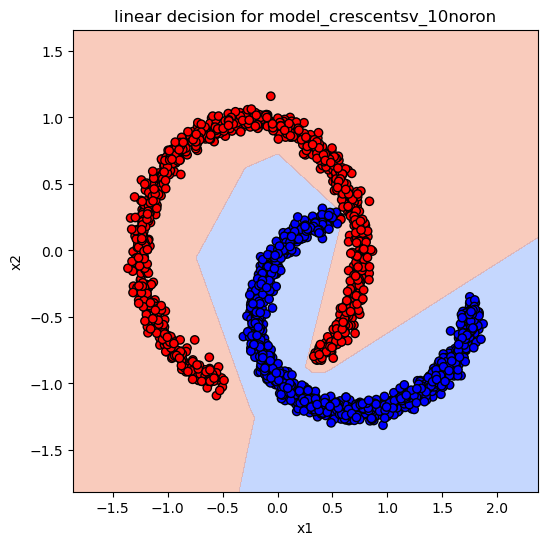

In [836]:
show_all(model_crescentsv_10noron,train_load_crescentsv,test_load_crescentsv,val_load_crescentsv,optimizer_cr_10n,400,"model_crescentsv_10noron",x_crescentsv,y_crescentsv)

همان طور که در نمودار بالا مشاهده میکنید مدل به تعداد نورون های بیشتر قدرت بیشتری در تفکیک داده های پیچیده دارد اینگونه میتوان گفت هرچه تعداد نورون ها بیشنر باشه تابع های بیچیده پیچیده تری را میتوان رسم کرد برای تفکیک داده ها 

از میزان ذقت در داده های اموزشی و داده هایی که توی اموزش نبوده خیلی خوب عمل کرده همچنین مقدار میانگین بالا نشان دهنده اینه که مدل به خوبی یاد گرفته از طرفی مدل پایدار هست چون std بالایی داره

نمودار تابع loss 
با هربار اموزش مدل بهبود پیدا میکند
اما چون من به دقت مناسبی رسیدم بیشتر از 400 بار اموزش ندادم

Epoch [100/400], Loss: 0.5931 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [200/400], Loss: 0.6270 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [300/400], Loss: 0.5216 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [400/400], Loss: 0.6815 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 


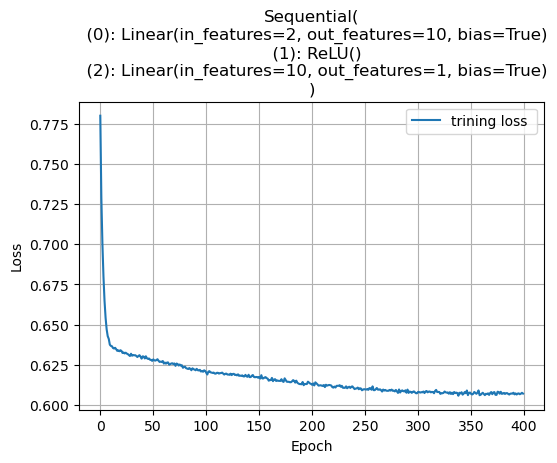

accuracy Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)
accuracy train = 64.85714285714286%  
accuracy validation = 60.25%  
accuracy test = 60.5%  
accuracy mean = 64.85714285714286%  
accuracy std = 0.0  


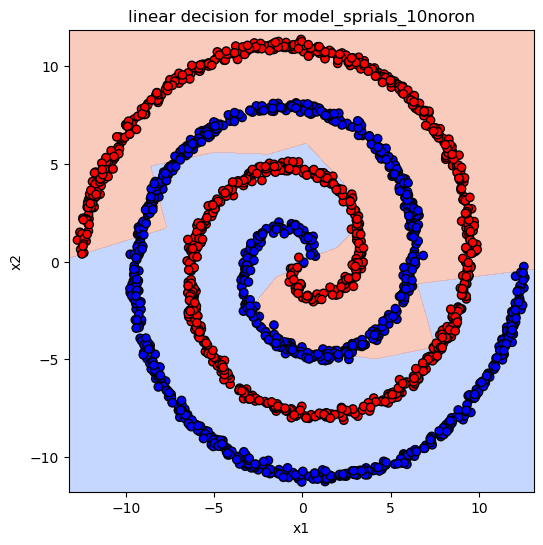

In [837]:
show_all(model_sprials_10noron,train_load_sprials,test_load_sprials,val_load_sprials,optimizer_sp_10n,400,"model_sprials_10noron",x_sprials,y_sprials)

به دلیل داده های پیچیده مدل نتوسته داده ها رو با دقت بالایی یاد بگیره به همین دلیل دقت پایینی داره 

Epoch [100/500], Loss: 0.6902 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [200/500], Loss: 0.5691 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [300/500], Loss: 0.3907 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [400/500], Loss: 0.2828 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [500/500], Loss: 0.3857 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 


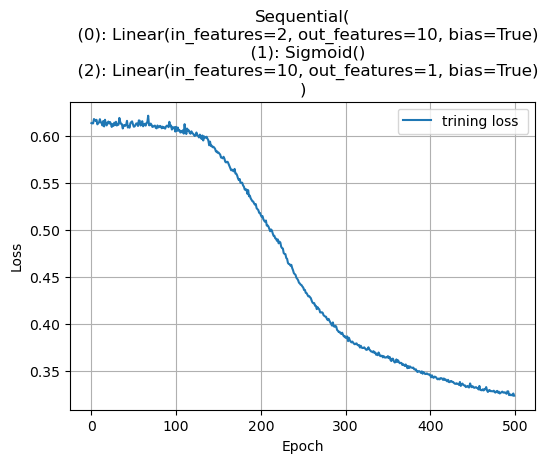

accuracy Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
)
accuracy train = 83.07142857142857%  
accuracy validation = 80.75%  
accuracy test = 84.0%  
accuracy mean = 83.07142857142857%  
accuracy std = 1.1102230246251565e-16  


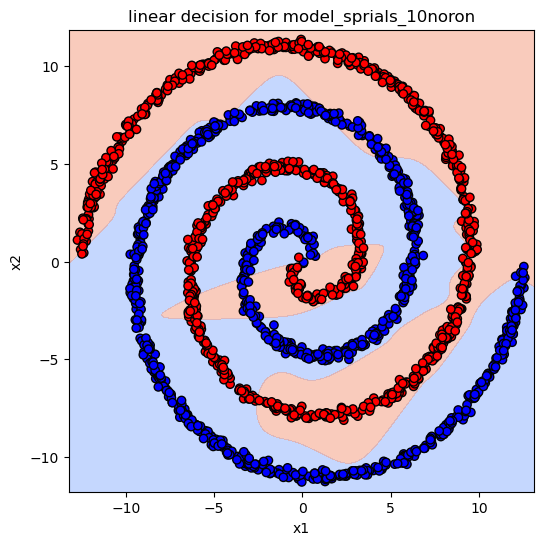

In [813]:
optimizer_sp_10n = torch.optim.Adam(model_sprials_10noron.parameters(),lr=1e-2)
show_all(model_sprials_10noron,train_load_sprials,test_load_sprials,val_load_sprials,optimizer_sp_10n,500,"model_sprials_10noron",x_sprials,y_sprials)

زیاد کردن نرخ یادگیری بهبود حاصل نکرد 

Epoch [100/500], Loss: 0.3800 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [200/500], Loss: 0.3885 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [300/500], Loss: 0.3954 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [400/500], Loss: 0.1787 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [500/500], Loss: 0.3965 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 


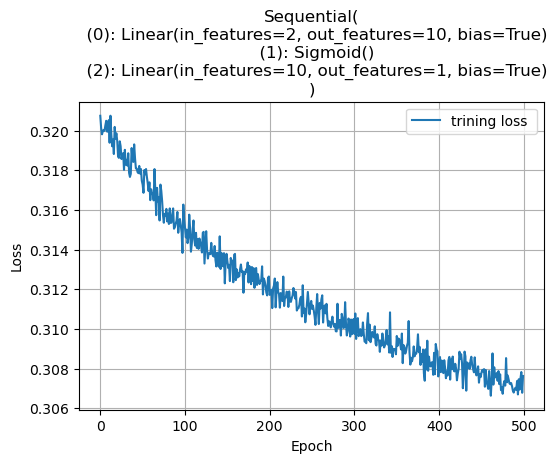

accuracy Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
)
accuracy train = 84.21428571428572%  
accuracy validation = 82.5%  
accuracy test = 85.0%  
accuracy mean = 84.21428571428572%  
accuracy std = 0.0  


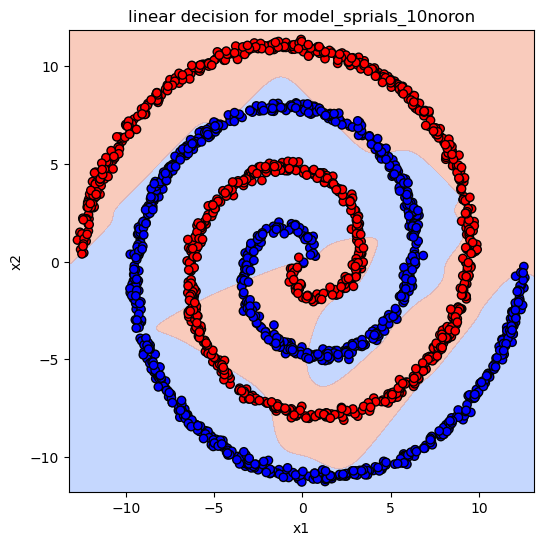

In [814]:
optimizer_sp_10n = torch.optim.Adam(model_sprials_10noron.parameters(),lr=1e-3)
show_all(model_sprials_10noron,train_load_sprials,test_load_sprials,val_load_sprials,optimizer_sp_10n,500,"model_sprials_10noron",x_sprials,y_sprials)

میتوان گفت مدل به 430 epoch
بیشتر زیاد تغییر نکرده نمودار loss
و به همگرایی رسیده 

Epoch [100/500], Loss: 0.4003 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [200/500], Loss: 0.2040 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [300/500], Loss: 0.3571 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [400/500], Loss: 0.3727 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 
Epoch [500/500], Loss: 0.3476 for Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
) 


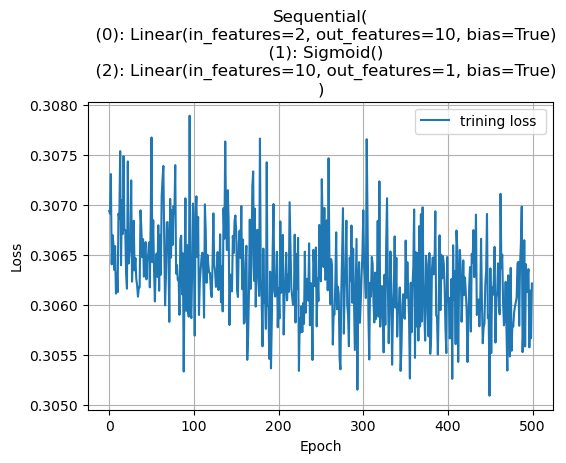

accuracy Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
)
accuracy train = 84.14285714285714%  
accuracy validation = 82.5%  
accuracy test = 85.0%  
accuracy mean = 84.14285714285715%  
accuracy std = 1.1102230246251565e-16  


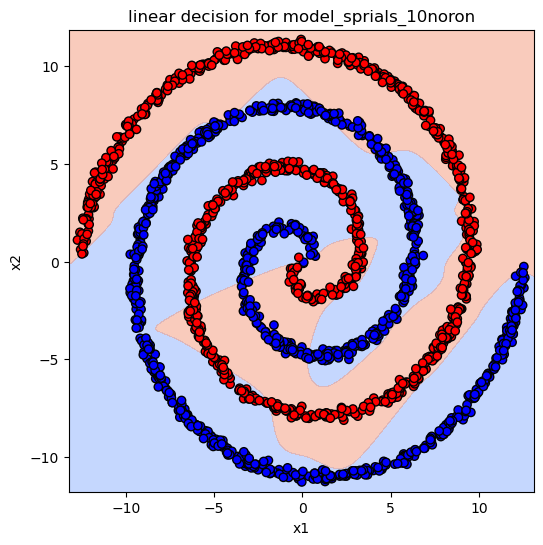

In [815]:
optimizer_sp_10n = torch.optim.Adam(model_sprials_10noron.parameters(),lr=1e-4)
show_all(model_sprials_10noron,train_load_sprials,test_load_sprials,val_load_sprials,optimizer_sp_10n,500,"model_sprials_10noron",x_sprials,y_sprials)

عنی مدل در حال یادگیری هست ولی به حدی از پایداری رسیده (دیگه به‌صورت محسوس کاهش پیدا نمی‌کنه)
مدل تقریباً همگرا شده و loss پایدار شده

In [816]:
# ساخت مدل های جدید با تعداد بیشتر و کمتر نورون

model_sprials_20noron = torch.nn.Sequential(
    torch.nn.Linear(2,20),
    torch.nn.Sigmoid(),
    torch.nn.Linear(20,1)
)
model_sprials_5noron = torch.nn.Sequential(
    torch.nn.Linear(2,5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5,1)
)

اینجا تابع بهینه سازی رو برای مدل هامون ایجاد میکینم و بعد مدل ها رو اموزش و تست میکنم 

Epoch [100/1000], Loss: 0.0018 for Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=1, bias=True)
) 
Epoch [200/1000], Loss: 0.0740 for Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=1, bias=True)
) 
Epoch [300/1000], Loss: 0.0003 for Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=1, bias=True)
) 
Epoch [400/1000], Loss: 0.0027 for Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=1, bias=True)
) 
Epoch [500/1000], Loss: 0.0019 for Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=1, bias=True)
) 
Epoch [600/1000], Loss: 0.0012 for Sequential(
  (0): Linear(in_features=2, out_features=20, bi

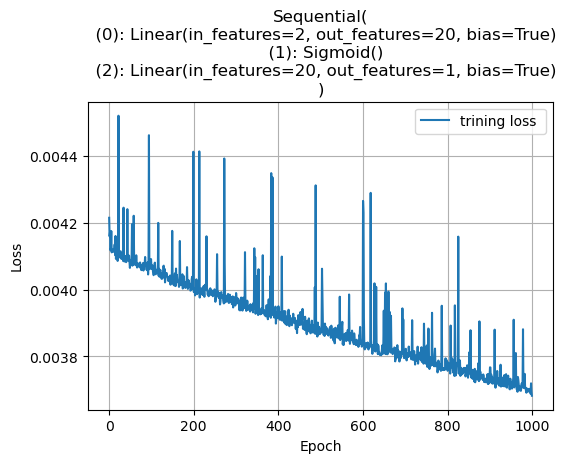

accuracy Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=1, bias=True)
)
accuracy train = 99.92857142857143%  
accuracy validation = 100.0%  
accuracy test = 100.0%  
accuracy mean = 99.92857142857144%  
accuracy std = 1.1102230246251565e-16  


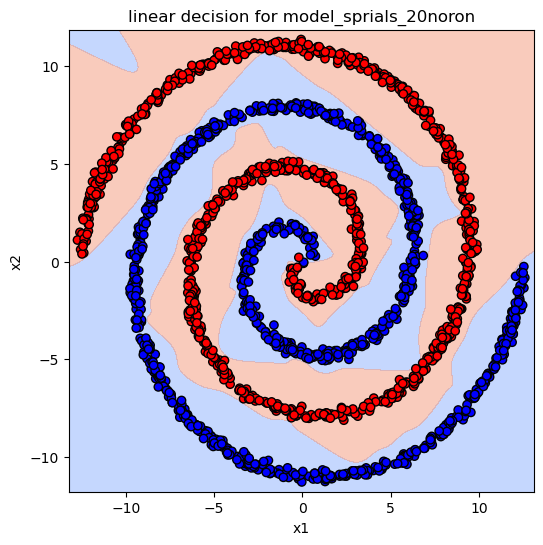

In [822]:
optimizer_sp_20n = torch.optim.Adam(model_sprials_20noron.parameters(),lr=1e-3)
show_all(model_sprials_20noron,train_load_sprials,test_load_sprials,val_load_sprials,optimizer_sp_20n,1000,"model_sprials_20noron",x_sprials,y_sprials)

همان طور در شکل مشخص هست با افزایش تعداد نورون ها مدل توانایی تفکیک داده های پیچیده رو بهتر یاد گرفته و دقت بالایی به ما داده و تقریبا به همگرایی رسیده 

Epoch [100/500], Loss: 0.5508 for Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=True)
) 
Epoch [200/500], Loss: 0.5459 for Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=True)
) 
Epoch [300/500], Loss: 0.7288 for Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=True)
) 
Epoch [400/500], Loss: 0.6210 for Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=True)
) 
Epoch [500/500], Loss: 0.6209 for Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=True)
) 


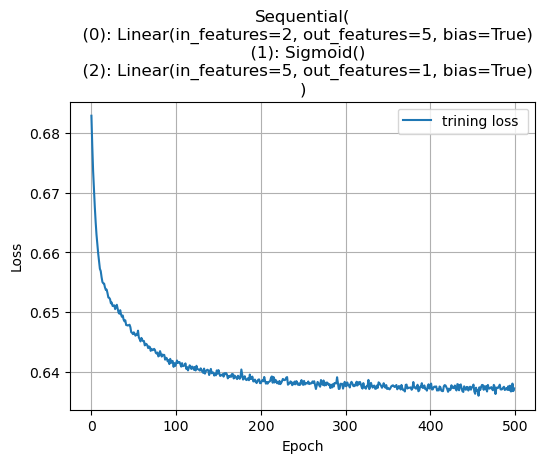

accuracy Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=True)
)
accuracy train = 61.71428571428571%  
accuracy validation = 53.0%  
accuracy test = 57.49999999999999%  
accuracy mean = 61.71428571428571%  
accuracy std = 0.0  


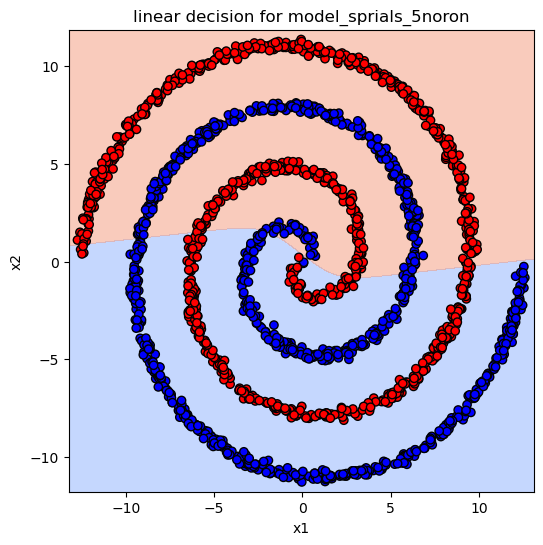

In [818]:
optimizer_sp_5n = torch.optim.Adam(model_sprials_5noron.parameters(),lr=1e-3)
show_all(model_sprials_5noron,train_load_sprials,test_load_sprials,val_load_sprials,optimizer_sp_5n,500,"model_sprials_5noron",x_sprials,y_sprials)

تعداد نورون های کمتر  یعنی مدل ضعیف تر در نتیجه مدل ما نسبت به داده های ما ضعفی است و قدرت تفکیک داده ها را ندارد و دقت پایینی دارد و تقریبا همگرا شده مدل

اینجا مدل کم برازش شده است 

Epoch [100/1000], Loss: 0.5738 for Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=1, bias=True)
) 
Epoch [200/1000], Loss: 0.1635 for Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=1, bias=True)
) 
Epoch [300/1000], Loss: 0.0403 for Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=1, bias=True)
) 
Epoch [400/1000], Loss: 0.0106 for Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=1, bias=True)
) 
Epoch [500/1000], Loss: 0.0035 for Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=1, bias=True)
) 
Epoch [600/1000], Loss: 0.0002 for Sequential(
  (0): Linear(in_features=2, out_features=30, bi

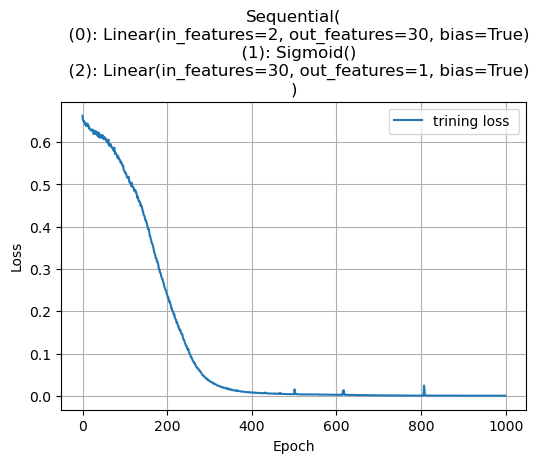

accuracy Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=1, bias=True)
)
accuracy train = 100.0%  
accuracy validation = 100.0%  
accuracy test = 100.0%  
accuracy mean = 100.0%  
accuracy std = 0.0  


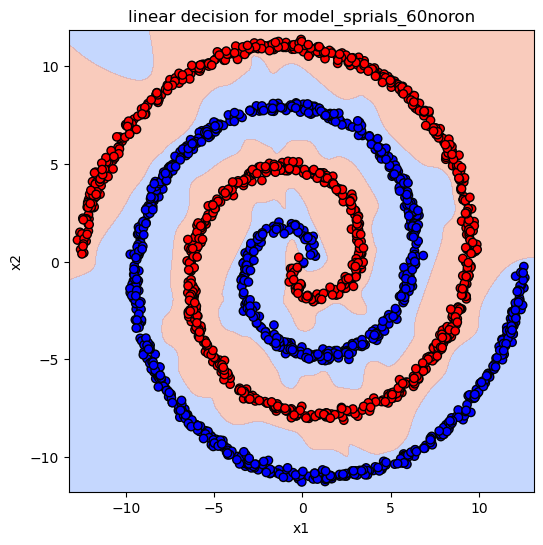

In [832]:
# مدل مناسب برای حل این مسئله 
model_sprials_30noron = torch.nn.Sequential(
    torch.nn.Linear(2,30),
    torch.nn.Sigmoid(),
    torch.nn.Linear(30,1)
    #  torch.nn.Sigmoid(),
    # torch.nn.Linear(10,1)
)
optimizer_sp_30n = torch.optim.Adam(model_sprials_30noron.parameters(),lr=1e-2)
show_all(model_sprials_30noron,train_load_sprials,test_load_sprials,val_load_sprials,optimizer_sp_30n,500,"model_sprials_30noron",x_sprials,y_sprials)

با افزودن لایه نورورن مدل توانایی بسیار بیشتری پیدا میکند و نتیجه اش می شود همگرایی با درصد دقت کامل
میتوان گفت مدل به بهترین عملکرد رسیده است 


که یعنی مدل ما بیش برازش یا کم برازش نکرده است 

دقت های train و validation و test یکی هستند 

<h1>نتیجه گیری : </h1>

بسته به نوع مسئله و داده ما تعداد نورون ها را کم یا زیاد میکنیم تا به مدل توانایی داده های پیچیده رو بدهیم 

با افزایش یا کاهش نرخ یادگیری مدل زود تر یا دیر تر به همگرایی می رسد اگر نرخ یادگیری را زیاد بگیریم ممکنم تابع loss نوسانی باشد 

تعداد دور های اموزش برای مدل باید به حدی باشد که نمودار 

loss

تغییر نکند  و به یک همگرایی رسیده باشد 

---------------------------------

| مدل             | دیتاست     | Accuracy (Val) | Accuracy (Train) | Accuracy (Test) | Accuracy (Mean) | Accuracy (Std) |
| --------------- | ---------- | -------------- | ---------------- | --------------- | --------------- | -------------- |
| مدل بهبود‌یافته | crescentsv | **100.0%**     | **99.92%**       | **100.0%**      | 99.92%          | 1.11e−16       |
| مدل بهبود‌یافته | spirals    | **100.0%**     | **100.0%**       | **100.0%**      | 100.0%          | 0              |
| مدل پایه        | crescentsv | 81.75%         | 80.2%            | 84.5%           | 80.2%           | 0              |
| مدل پایه        | spirals    | 52.5%          | 61.1%            | 56.0%           | 61.1%           | 1.11e−16       |


سعید صفائی مایوان 